# Actividad 4 - Módulo 3

## Configuración inicial

In [13]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from pathlib import Path

# Visualización en línea
%matplotlib inline

# Ruta del archivo (relativa al notebook)
script_dir = Path().resolve()
datos_dir = script_dir / 'sensores_industriales.csv'

## 1. Carga del archivo y exploración

In [14]:
# Cargar el archivo CSV con marcadores de valores faltantes
df = pd.read_csv(datos_dir, na_values=['NA', '-999', '?'])
df_original = df.copy()

print("Dimensiones del dataset:", df.shape)
print("\nTipos de datos por columna:\n", df.dtypes)
print("\nCantidad de valores faltantes por columna:\n", df.isnull().sum())

Dimensiones del dataset: (150, 4)

Tipos de datos por columna:
 id               int64
temperatura    float64
presion        float64
estado          object
dtype: object

Cantidad de valores faltantes por columna:
 id             0
temperatura    9
presion        9
estado         9
dtype: int64


## 2. Detección de valores perdidos 

In [15]:
# Eliminación de filas con más del 50% de valores nulos
limite_nulos = df.shape[1] * 0.5
df = df[df.isnull().sum(axis=1) < limite_nulos]
df.head()

,id,temperatura,presion,estado
0,1,60.000000,1.020020,OK
1,2,21.585207,1.023858,OK
2,3,23.943066,0.982799,NaN
3,4,26.569090,1.019290,ALERTA
4,5,21.297540,1.021723,FALLA


## 3. Tratamiento de valores perdidos 

In [16]:
# Imputación con KNN para columnas numéricas
columnas_numericas = ['temperatura', 'presion']
knn_imputer = KNNImputer(n_neighbors=3)
df[columnas_numericas] = knn_imputer.fit_transform(df[columnas_numericas])

# Imputación con la moda para columna categórica 'estado'
imputer_estado = SimpleImputer(strategy='most_frequent')
df[['estado']] = imputer_estado.fit_transform(df[['estado']])
df.head()

,id,temperatura,presion,estado
0,1,60.000000,1.020020,OK
1,2,21.585207,1.023858,OK
2,3,23.943066,0.982799,OK
3,4,26.569090,1.019290,ALERTA
4,5,21.297540,1.021723,FALLA


# 4. Detección y tratamiento de outliers

In [17]:
def eliminar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    print(f"Outliers en '{columna}': fuera del rango [{limite_inferior:.2f}, {limite_superior:.2f}]")
    return df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

df = eliminar_outliers_iqr(df, 'temperatura')
df = eliminar_outliers_iqr(df, 'presion')

Outliers en 'temperatura': fuera del rango [14.91, 28.12]
Outliers en 'presion': fuera del rango [0.90, 1.12]


## 5. Visualización antes y después del tratamiento

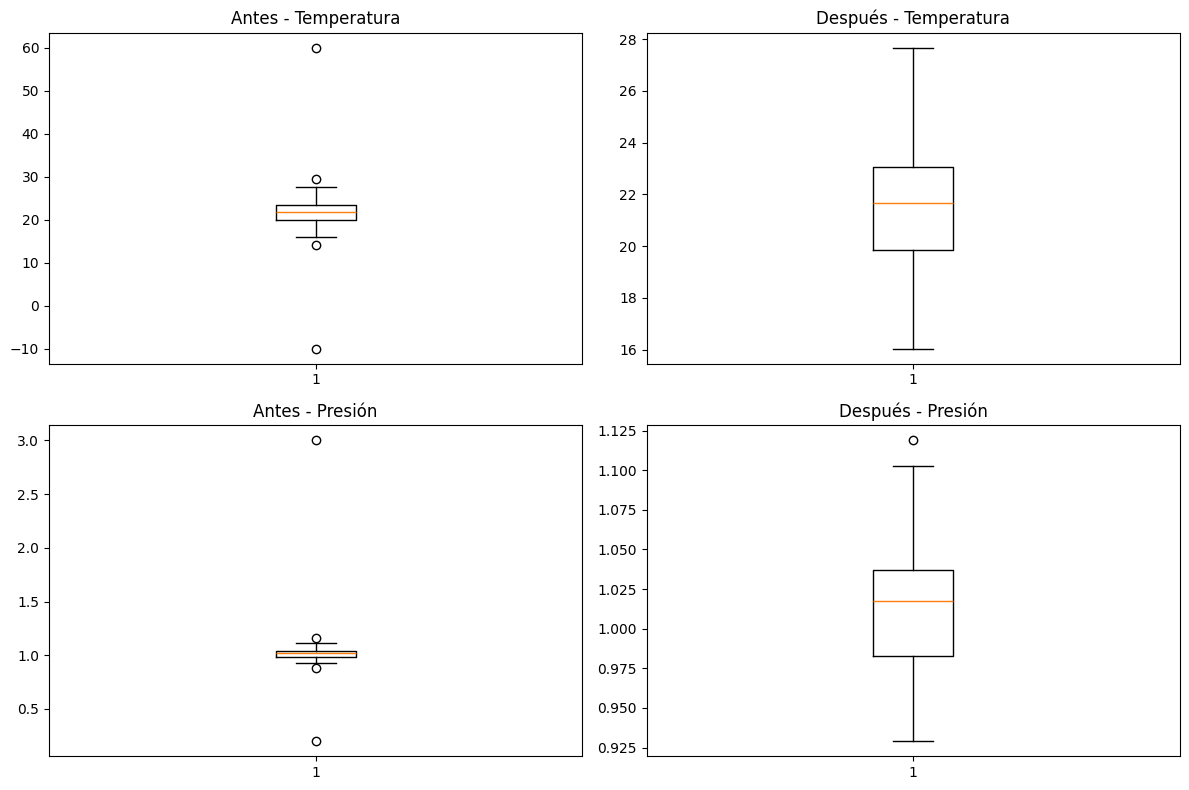


Resumen estadístico ANTES del tratamiento:
       temperatura     presion
count   141.000000  141.000000
mean     21.723993    1.021449
std       5.062500    0.185733
min     -10.000000    0.200000
25%      19.840467    0.982284
50%      21.783970    1.016927
75%      23.420777    1.037184
max      60.000000    3.000000

Resumen estadístico DESPUÉS del tratamiento:
       temperatura     presion
count   138.000000  138.000000
mean     21.547578    1.013374
std       2.642100    0.037341
min      16.037293    0.928994
25%      19.853811    0.982981
50%      21.673400    1.017193
75%      23.061217    1.037009
max      27.658558    1.118807


In [18]:
# Boxplots comparativos antes y después
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Temperatura
axs[0, 0].boxplot(df_original['temperatura'].dropna())
axs[0, 0].set_title('Antes - Temperatura')

axs[0, 1].boxplot(df['temperatura'])
axs[0, 1].set_title('Después - Temperatura')

# Presión
axs[1, 0].boxplot(df_original['presion'].dropna())
axs[1, 0].set_title('Antes - Presión')

axs[1, 1].boxplot(df['presion'])
axs[1, 1].set_title('Después - Presión')

plt.tight_layout()
plt.show()

# Tablas resumen estadísticas
print("\nResumen estadístico ANTES del tratamiento:")
print(df_original[['temperatura', 'presion']].describe())
print("\nResumen estadístico DESPUÉS del tratamiento:")
print(df[['temperatura', 'presion']].describe())

## 6. Documentación del pipeline y Guardar el dataset limpio

### Documentación del pipeline de limpieza de datos

**Archivo:** `sensores_industriales.csv`  
**Objetivo:** Preprocesar un dataset con registros de sensores industriales, tratando valores perdidos y outliers para obtener datos listos para análisis.

---

### 1. Carga y exploración inicial
Se cargó el archivo CSV utilizando `pandas`, especificando valores especiales como `'NA'`, `'-999'` y `'?'` para ser tratados como valores faltantes (`NaN`). Se realizó una exploración básica que incluyó:

- Cantidad de filas y columnas
- Tipos de datos por variable
- Conteo de valores faltantes

---

### 2. Detección y tratamiento de valores perdidos
Se eliminaron las filas con más del 50% de sus datos faltantes, ya que contenían información poco útil.  

Luego:
- Las variables numéricas (`temperatura`, `presión`) fueron imputadas utilizando **KNNImputer (k=3)**, lo que permite estimar valores considerando la similitud con registros vecinos.
- La variable categórica `estado` se imputó con la **moda** (valor más frecuente), asegurando coherencia sin introducir categorías nuevas.

---

### 3. Detección y tratamiento de outliers
Se aplicó la **regla de 1.5 × IQR** para detectar outliers en `temperatura` y `presión`. Los valores fuera de los rangos normales fueron eliminados para evitar distorsiones en los análisis posteriores. Esta técnica es adecuada en datos no normalizados o con valores extremos.

---

### 4. Visualización antes y después
Se generaron **boxplots comparativos** y estadísticas descriptivas (`mean`, `std`, `min`, `max`) para evidenciar los cambios en la distribución de datos antes y después del tratamiento.

---

### 5. Exportación final
Los datos limpios se guardaron como `datos_limpios.csv`, listos para ser utilizados en análisis exploratorios, modelado o visualización.


In [19]:
# Guardar el dataset limpio
ruta_salida = script_dir / 'datos_limpios.csv'
df.to_csv(ruta_salida, index=False)
print(" Dataset limpio guardado en:", ruta_salida)

 Dataset limpio guardado en: D:\Dropbox\Dropbox\Ingeniería de datos\Módulo 3\Clase 4\Actividad 4\datos_limpios.csv
